In [1]:
# Libraries
# ======================================================================================
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import  HistGradientBoostingRegressor
from lightgbm import LGBMRegressor


# pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
# skforecast
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

import warnings

c:\Users\progra.DESKTOP-GV4Q93K\miniconda3\envs\last\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Se leen y transforman los datos

In [2]:
df = pd.read_csv("Final-db.csv")
# Eliminar los espacios adicionales en las fechas
df['date'] = df['date'].str.strip()

# Mapeo de los nombres de los meses en español a los nombres en inglés
meses = {
    'ene': 'Jan',
    'feb': 'Feb',
    'mar': 'Mar',
    'abr': 'Apr',
    'may': 'May',
    'jun': 'Jun',
    'jul': 'Jul',
    'ago': 'Aug',
    'sep': 'Sep',
    'oct': 'Oct',
    'nov': 'Nov',
    'dic': 'Dec'
}

# Función para convertir los nombres de los meses en español a inglés
def convertir_meses(fecha):
    for mes_es, mes_en in meses.items():
        fecha = fecha.replace(mes_es, mes_en)
    return fecha

# Aplicar la función a la columna de fecha
df['date'] = df['date'].apply(convertir_meses)

# Convertir la columna de fecha a datetime
df['date'] = pd.to_datetime(df['date'], format='%d %b %Y')

Se crean las variables exogenas y se limpia el dataframe

In [3]:

df = df.drop(columns=['Unnamed: 0',"index","Total libre de impuestos","Indefinido total $","Indefinido ctdad"])
df = df.rename(columns={"date":"Fecha","Encoded Products":"Producto"})
df['Fecha'] = pd.to_datetime(df['Fecha'], format="mixed")
df.columns = df.columns.str.replace("total $", "Precio por unidad")
df.columns = df.columns.str.replace("ctdad", "Cantidad")
def div(numerator, denominator):
  return lambda row: 0.0 if row[denominator] == 0 else float(row[numerator]/row[denominator])
for i in range(2, len(df.columns)-1,2):
    df[df.columns[i]] = df.apply(div(df.columns[i], df.columns[i+1]), axis=1)
df = df.set_index('Fecha')




De igual manera se eliminan los valores con menos de 50 ventas en 2023

In [4]:
data = pd.DataFrame()
for i in df["Producto"].unique():
        x =pd.DataFrame(df[df["Producto"]==i].loc[:].groupby("Fecha").sum()["Ctdad Ordenada"].asfreq("D", fill_value=0)).rename(columns={"Ctdad Ordenada":i})
        data = pd.concat([data,x], axis=1)
data.fillna(0, inplace=True)
exog = pd.DataFrame()
exog["Mes"] = data.index.month
data["Dia"] = data.index.day
exog["Dia de la semana"] = data.index.dayofweek
exog.index = data.index
exog = pd.get_dummies(exog, columns=["Mes","Dia de la semana"],dtype=int)
exog = pd.concat([exog, data["Dia"]], axis=1)
exog["Dia"].replace(to_replace=[13,14,15,16,17,18,28,29,30,31,1,2], value=1, inplace=True)
exog["Dia"].replace(to_replace=[3,4,5,6,7,8,9,10,11,12,19,20,21,22,23,24,25,26,27,28], value=0, inplace=True)
for i in data.columns:
    if data.loc["2023-01-01":,i].sum() < 50:
        data = data.drop(columns=i,axis=1)
data.drop(columns="Dia", inplace=True)
data = data[data.sum().sort_values(ascending=False).index[0:20]]
data.head()

,Producto 273,Producto 0,Producto 1,Producto 5,Producto 8,Producto 21,Producto 12,Producto 22,Producto 186,Producto 20,Producto 33,Producto 245,Producto 16,Producto 17,Producto 38,Producto 134,Producto 37,Producto 59,Producto 248,Producto 122
Fecha,,,,,,,,,,,,,,,,,,,,
2022-01-02,0.0,10.5,35.0,14.0,21.0,7.0,7.0,0.0,0.0,3.5,0.0,0.0,3.5,0.0,0.0,0.0,7.0,0.0,0.0,0.0
2022-01-03,0.0,38.5,17.5,21.0,0.0,7.0,10.5,3.5,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,3.5,0.0,0.0
2022-01-04,0.0,56.0,3.5,21.0,10.5,3.5,3.5,7.0,0.0,3.5,7.0,0.0,3.5,0.0,0.0,0.0,3.5,0.0,0.0,0.0
2022-01-05,0.0,49.0,14.0,10.5,10.5,0.0,7.0,3.5,0.0,0.0,0.0,0.0,3.5,3.5,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-06,0.0,17.5,7.0,10.5,3.5,3.5,7.0,0.0,0.0,0.0,0.0,0.0,7.0,3.5,0.0,0.0,0.0,3.5,0.0,0.0


In [5]:
exog.head()

,Mes_1,Mes_2,Mes_3,Mes_4,Mes_5,Mes_6,Mes_7,Mes_8,Mes_9,Mes_10,Mes_11,Mes_12,Dia de la semana_0,Dia de la semana_1,Dia de la semana_2,Dia de la semana_3,Dia de la semana_4,Dia de la semana_5,Dia de la semana_6,Dia
Fecha,,,,,,,,,,,,,,,,,,,,
2022-01-02,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2022-01-03,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2022-01-04,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2022-01-05,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2022-01-06,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


# Se divide el test en validacion, test y entrenamiento

In [6]:
# Split data into train-validation-test
# ======================================================================================
end_train = '2023-10-30'
end_val = '2023-11-30'

data_train = data.loc[:end_train, :].copy()
data_val   = data.loc[end_train:end_val, :].copy()
data_test  = data.loc[end_val:, :].copy()
exog_train = exog.loc[:end_train, :].copy()
exog_val   = exog.loc[end_train:end_val, :].copy()
exog_test  = exog.loc[end_val:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2022-01-02 00:00:00 --- 2023-10-30 00:00:00  (n=667)
Validation dates : 2023-10-30 00:00:00 --- 2023-11-30 00:00:00  (n=32)
Test dates       : 2023-11-30 00:00:00 --- 2023-12-31 00:00:00  (n=32)


Algunas de los trends que hay

C:\Users\progra.DESKTOP-GV4Q93K\AppData\Local\Temp\ipykernel_19048\1578984712.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data.iloc[:, :4].plot(


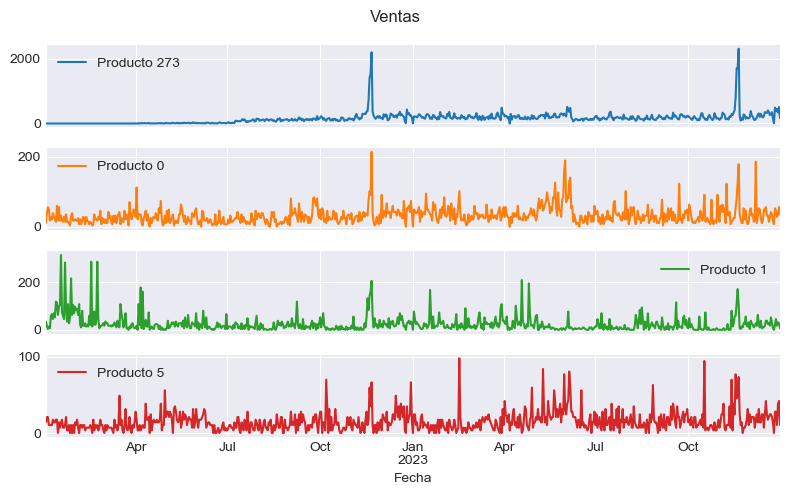

In [7]:
# Plot time series
# ======================================================================================
fig, ax = plt.subplots(figsize=(8, 5))
data.iloc[:, :4].plot(
    legend   = True,
    subplots = True, 
    sharex   = True,
    title    = 'Ventas',
    ax       = ax, 
)
fig.tight_layout();

# Se hacen las pruebas de estacionalidad

Test stationarity for original series
-------------------------------------
ADF Statistic: -6.8466637778759205, p-value: 1.7358130411528209e-09
KPSS Statistic: 2.372477848531467, p-value: 0.01

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -9.642266345299063, p-value: 1.5098298316387997e-16
KPSS Statistic: 0.17723174229793687, p-value: 0.1

Test stationarity for differenced series (order=2)
--------------------------------------------------
ADF Statistic: -12.074263451651005, p-value: 2.309630710552708e-22
KPSS Statistic: 0.09212782654564701, p-value: 0.1


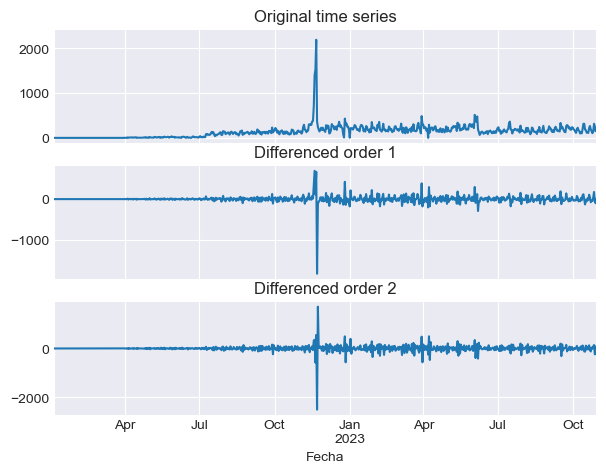

In [8]:
# Test stationarity
# ==============================================================================
warnings.filterwarnings("ignore")

data_diff_1 = data_train.loc[:,"Producto 273"].diff().dropna()
data_diff_2 = data_diff_1.diff().dropna()

print('Test stationarity for original series')
print('-------------------------------------')
adfuller_result = adfuller(data.loc[:,"Producto 273"])
kpss_result = kpss(data.loc[:,"Producto 273"])
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_1)
kpss_result = kpss(data.loc[:,"Producto 273"].diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_2)
kpss_result = kpss(data.loc[:,"Producto 273"].diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

warnings.filterwarnings("default")

# Plot series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
data.loc[:,"Producto 273"].plot(ax=axs[0], title='Original time series')
data_diff_1.plot(ax=axs[1], title='Differenced order 1')
data_diff_2.plot(ax=axs[2], title='Differenced order 2');

Y de autocorrelacion

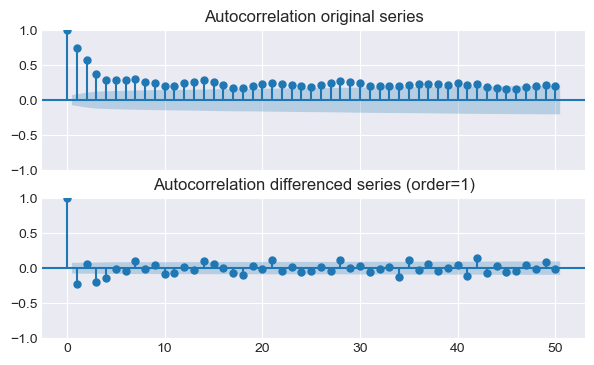

In [9]:
# Autocorrelation plot for original and differenced series
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 4), sharex=True)
plot_acf(data.loc[:,"Producto 273"], ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelation original series')
plot_acf(data_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelation differenced series (order=1)');

De igual manera de correlación parcial

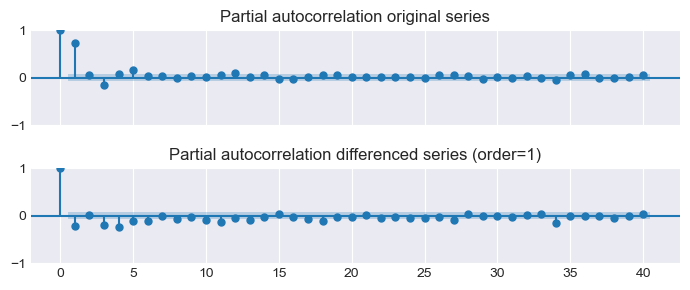

In [10]:
# Partial autocorrelation plot for original and differenced series
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 3), sharex=True)
plot_pacf(data.loc[:,"Producto 273"], ax=axs[0], lags=40, alpha=0.05)
axs[0].set_title('Partial autocorrelation original series')
plot_pacf(data_diff_1, ax=axs[1], lags=40, alpha=0.05)
axs[1].set_title('Partial autocorrelation differenced series (order=1)');
plt.tight_layout();

In [11]:
from tqdm import tqdm
from functools import partialmethod

## Se obtienen los mejores hiperparametros atraves de autosarima y se guardan en un archivo

In [12]:
# Hyperparameter search and backtesting of each item's model
# ======================================================================================
items = []
mae_values  = []
dictes = {}
models = []
lags_grid = [7, 14, 21]
param_grid = {'order': [(1, 0, 1), (12, 2, 0)],
             'seasonal_order': [(1, 0, 1, 54),(1, 0, 1, 12)],
             'trend': [None, 'n', 'c']}

for i, item in enumerate(data.columns):
    model = auto_arima(
            y                 = data.loc[:end_val, item],
            start_p           = 0,
            start_q           = 0,
            max_p             = 3,
            max_q             = 3,
            seasonal          = True,
            test              = 'adf',
            exog = exog.loc[:end_val],
            m                 = 12, # Seasonal period
            d                 = None, # The algorithm will determine 'd'
            D                 = None, # The algorithm will determine 'D'
            trace             = True,
            error_action      = 'ignore',
            suppress_warnings = True,
            stepwise          = True
        )
    models.append(model)
    

    uni_series_mae = pd.Series(
                     data  = mae_values,
                     index = items,
                     name  = 'uni_series_mae'
                 )

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=9203.028, Time=0.89 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=9302.979, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=8738.579, Time=0.43 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=8963.173, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9634.031, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=8737.793, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=8738.634, Time=0.16 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=8740.613, Time=0.37 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=8738.072, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=8738.578, Time=0.29 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=8979.485, Time=0.26 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=8733.026, Time=0.41 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=8734.305, Time=1.06 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=8734.325, Time=1.03 sec
 ARIMA(2,0,1)(1,0,1

In [13]:
datamod = pd.DataFrame(models)
datamod.index = data.columns
datamod.rename(columns={0:"Model"}, inplace=True)
datamod.to_csv("ModelsSari.csv")

# Se procede a hacer un modelo para cada uno de ellos.

Se prueba para un producto

In [14]:

forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=datamod.loc["Producto 273"][0].order, seasonal_order=datamod.loc["Producto 273"][0].seasonal_order, maxiter=500),
             )

metric_m1, predictions_m1 = backtesting_sarimax(
                                forecaster            = forecaster,
                                y                     = data.loc[:,"Producto 273"],
                                initial_train_size    = len(data.loc[:end_val]),
                                steps                 = 12,
                                exog = exog,
                                metric                = 'mean_squared_error',
                                refit                 = True,
                                n_jobs                = "auto",
                                suppress_warnings_fit = True,
                                verbose               = False,
                                show_progress         = True
                            )

C:\Users\progra.DESKTOP-GV4Q93K\AppData\Local\Temp\ipykernel_19048\2345847679.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  regressor=Sarimax(order=datamod.loc["Producto 273"][0].order, seasonal_order=datamod.loc["Producto 273"][0].seasonal_order, maxiter=500),
100%|██████████| 3/3 [00:39<00:00, 13.15s/it]


Metric (mean_absolute_error) for grid search model: 17949.30396715978


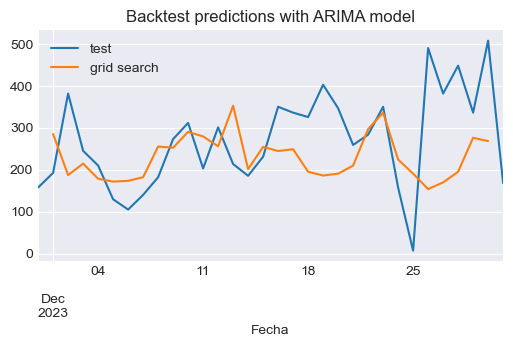

In [15]:
# Compare predictions
# ==============================================================================
print(f"Metric (mean_absolute_error) for grid search model: {metric_m1}")

fig, ax = plt.subplots(figsize=(6, 3))
data.loc[end_val:,"Producto 273"].plot(ax=ax, label='test')
predictions_m1 = predictions_m1.shift(-1).rename(columns={'pred': 'grid search'})
predictions_m1.plot(ax=ax)
ax.set_title('Backtest predictions with ARIMA model')
ax.legend();

Se corre cada modelo personalizado para cada producto

In [16]:
month_pred = pd.DataFrame()
week_pred = pd.DataFrame()

In [17]:
for i in datamod.index:
    forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=datamod.loc[i][0].order, seasonal_order=datamod.loc[i][0].seasonal_order, maxiter=500),
             )
    forecaster.fit(y=data.loc[:end_val,i], exog=exog[:end_val])
    month_pred[i] = forecaster.predict(steps=31, exog=exog.loc["2023-12-01":, :])
    week_pred[i] = forecaster.predict(steps=8, exog=exog.loc["2023-12-01":, :])

C:\Users\progra.DESKTOP-GV4Q93K\AppData\Local\Temp\ipykernel_19048\2969500660.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  regressor=Sarimax(order=datamod.loc[i][0].order, seasonal_order=datamod.loc[i][0].seasonal_order, maxiter=500),
C:\Users\progra.DESKTOP-GV4Q93K\AppData\Local\Temp\ipykernel_19048\2969500660.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  regressor=Sarimax(order=datamod.loc[i][0].order, seasonal_order=datamod.loc[i][0].seasonal_order, maxiter=500),
C:\Users\progra.DESKTOP-GV4Q93K\AppData\Local\Temp\ipykernel_19048\2969500660.py:3: FutureWarning: Series.__getitem__ treating keys as posit

Se ayuda al modelo por si llega a estimar valores negativos

In [18]:
# cambiar valores negativos a 0
month_pred[month_pred<0] = 0
week_pred[week_pred<0] = 0

In [19]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

Se obtienen las estadisticas descriptivas de cada modelo por mes y por semana

In [20]:
stats_mes = pd.DataFrame()
for i in month_pred.columns:
    y_pred = month_pred[i]
    y_test = data.loc["2023-12-01":"2023-12-31",i]
    mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
    mape = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred)
    mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
    r2 = r2_score(y_true=y_test, y_pred=y_pred)
    mape2 = abs((y_pred - y_test)/y_test).replace([np.inf, -np.inf], np.log(0.9999999999999999999999999)).dropna().sum()/30
    mape3 = (np.abs((y_test - y_pred)/np.where(y_test==0, 1, y_test))).mean()
    smape = 1/len(y_test) * np.sum(2*np.abs(y_pred - y_test)/(np.abs(y_pred) + np.abs(y_test))*100)
    valor_real = y_test.sum()
    valor_pred = y_pred.sum()
    error = (valor_real - valor_pred)/valor_real
    error_semanal = error/4 * 100
    stats_mes = pd.concat([stats_mes, pd.DataFrame({"Producto":i, "MAE":mae, "MSE":mse, "R2":r2, "SMAPE": smape,"MAPE lib":mape,"MAPE2":mape2,"MAPE3":mape3, "valor real": 
        valor_real, "valor predecido": valor_pred, "error":error*100, "error por semana": error_semanal}, index=[0])], axis=0)
stats_mes

C:\Users\progra.DESKTOP-GV4Q93K\AppData\Local\Temp\ipykernel_19048\1630151674.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  error = (valor_real - valor_pred)/valor_real


,Producto,MAE,MSE,R2,SMAPE,MAPE lib,MAPE2,MAPE3,valor real,valor predecido,error,error por semana
0,Producto 273,107.309473,18019.026755,-0.387650,43.063818,1.855757e+00,1.917615,1.855757,8452.5,7084.204968,16.188051,4.047013
0,Producto 0,20.262914,1048.008900,-0.122883,50.102742,9.415877e-01,0.972974,0.941588,1186.5,1416.896506,-19.418163,-4.854541
0,Producto 1,14.262463,291.643859,-0.361855,60.481885,5.240341e+15,1.081707,2.210403,731.5,940.289479,-28.542649,-7.135662
0,Producto 5,7.463292,93.859860,-0.032708,38.733354,3.451022e+15,0.440212,1.192293,651.0,689.115308,-5.854886,-1.463722
0,Producto 8,9.031194,110.910652,-0.397948,70.534206,7.991283e+15,0.961057,2.704476,399.0,525.947695,-31.816465,-7.954116
0,Producto 21,5.705833,92.586240,-6.964140,97.167616,1.276984e+16,0.634613,3.449616,133.0,231.235757,-73.861472,-18.465368
0,Producto 12,2.658235,9.387431,-0.187797,120.277525,2.972964e+15,0.416663,1.063353,108.5,67.316443,37.957196,9.489299
0,Producto 22,2.959856,12.400126,-0.250356,126.690667,1.031810e+16,0.086434,2.374725,70.0,123.206525,-76.009321,-19.002330
0,Producto 186,4.708370,33.479094,-0.152942,87.772322,7.752684e+15,0.363726,2.073435,203.0,203.983398,-0.484433,-0.121108
0,Producto 20,1.725111,4.467942,-0.288623,159.704041,4.550007e+15,0.187940,1.192182,35.0,44.160442,-26.172692,-6.543173


In [21]:
stats_semana = pd.DataFrame()
for i in month_pred.columns:
    y_pred = week_pred[i]
    y_test = data.loc["2023-12-01":"2023-12-8",i]
    mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
    mape = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred)
    mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
    r2 = r2_score(y_true=y_test, y_pred=y_pred)
    mape2 = abs((y_pred - y_test)/y_test).replace([np.inf, -np.inf], np.log(0.9999999999999999999999999)).dropna().sum()/30
    mape3 = (np.abs((y_test - y_pred)/np.where(y_test==0, 1, y_test))).mean()
    smape = 1/len(y_test) * np.sum(2*np.abs(y_pred - y_test)/(np.abs(y_pred) + np.abs(y_test))*100)
    valor_real = y_test.sum()
    valor_pred = y_pred.sum()
    error = (valor_real - valor_pred)/valor_real *100
    stats_semana = pd.concat([stats_semana, pd.DataFrame({"Producto":i, "MAE":mae, "MSE":mse, "R2":r2, "SMAPE": smape,"MAPE lib":mape,"MAPE2":mape2,"MAPE3":mape3, "valor real": 
        valor_real, "valor predecido": valor_pred, "error":error}, index=[0])], axis=0)
stats_semana

C:\Users\progra.DESKTOP-GV4Q93K\AppData\Local\Temp\ipykernel_19048\2497161326.py:14: RuntimeWarning: invalid value encountered in scalar divide
  error = (valor_real - valor_pred)/valor_real *100
C:\Users\progra.DESKTOP-GV4Q93K\AppData\Local\Temp\ipykernel_19048\2497161326.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  error = (valor_real - valor_pred)/valor_real *100


,Producto,MAE,MSE,R2,SMAPE,MAPE lib,MAPE2,MAPE3,valor real,valor predecido,error
0,Producto 273,48.840042,3435.755726,0.481556,26.741805,2.740573e-01,0.073082,0.274057,1585.5,1502.171660,5.255651
0,Producto 0,34.295611,3017.404290,-0.056029,67.117765,1.074584e+00,0.286556,1.074584,392.0,345.868444,11.768254
0,Producto 1,13.392477,211.902942,-1.009228,61.312046,1.420857e+00,0.378895,1.420857,164.5,233.788619,-42.120741
0,Producto 5,4.585538,41.088805,-0.350113,26.421688,4.100188e-01,0.109338,0.410019,150.5,173.331844,-15.170660
0,Producto 8,10.087327,117.351141,-2.855974,111.970440,1.727572e+16,0.364641,5.203384,45.5,126.198619,-177.359602
0,Producto 21,13.464725,318.785556,-51.046621,118.020719,3.150247e+16,0.459531,8.718193,28.0,120.143714,-329.084691
0,Producto 12,3.277976,13.451169,-3.685033,109.881526,6.680354e-01,0.178143,0.668035,38.5,12.276192,68.113787
0,Producto 22,3.423491,13.692747,-9.219660,175.378907,1.535739e+16,0.001026,3.413873,3.5,30.887930,-782.512296
0,Producto 186,6.141932,46.296216,-0.382138,130.359322,1.608724e+16,0.069439,3.832481,38.5,52.124169,-35.387452
0,Producto 20,1.672703,3.994915,-1.981627,175.000000,5.562860e+15,0.033333,1.360203,3.5,9.881625,-182.332146


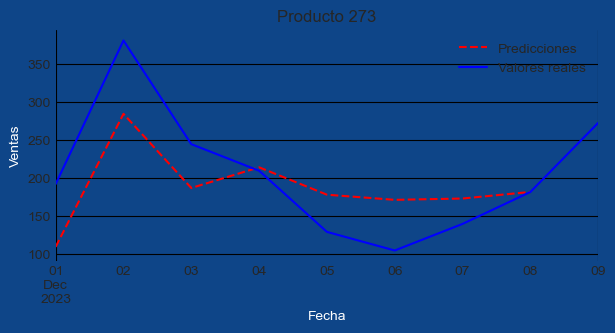

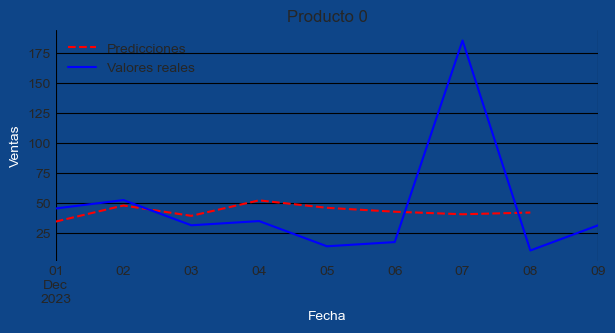

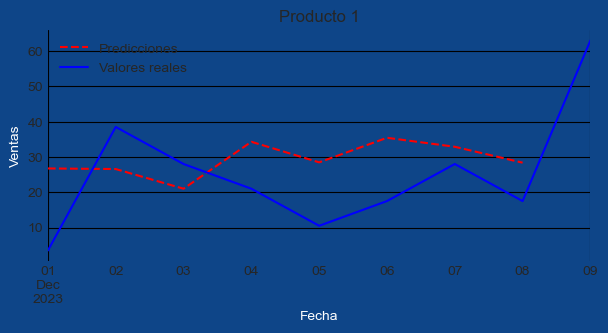

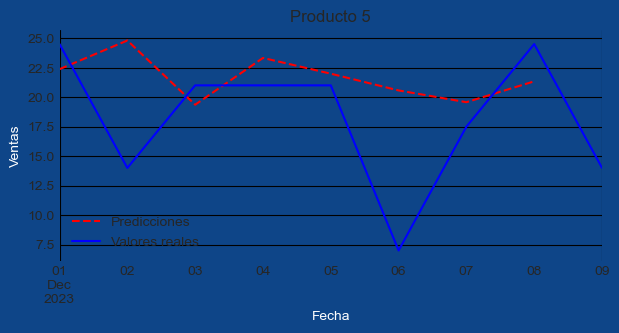

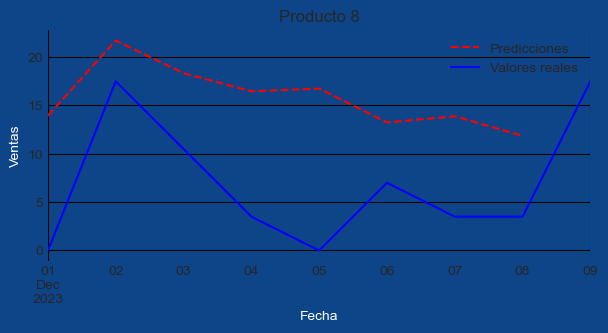

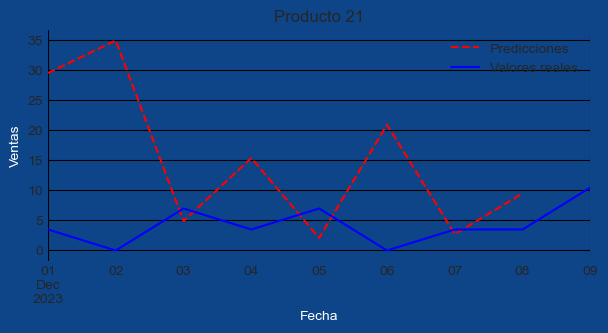

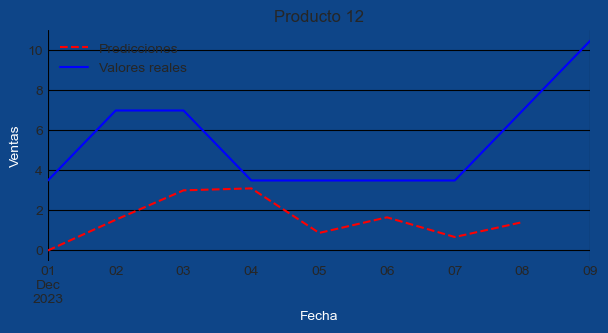

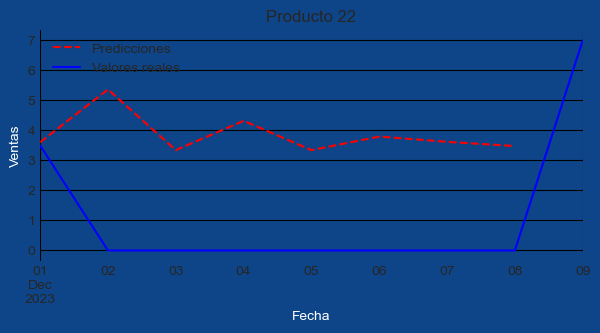

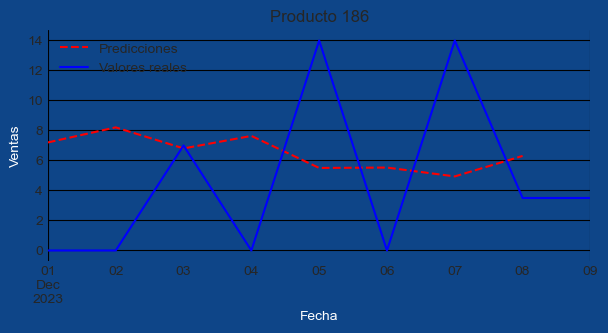

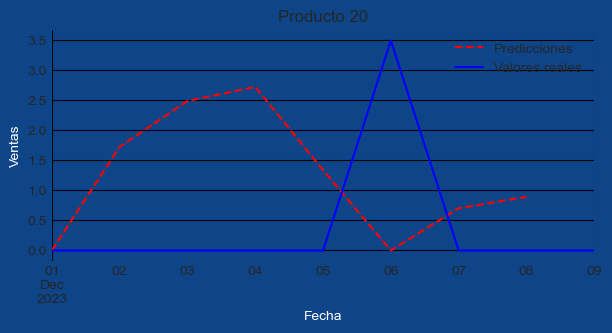

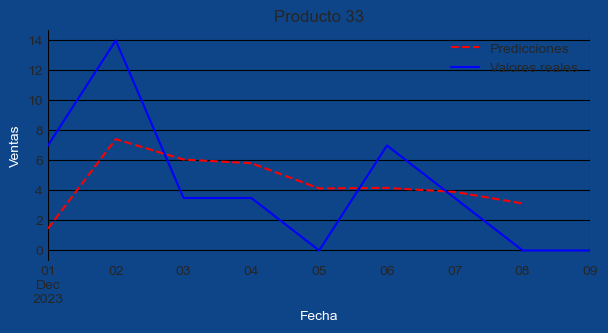

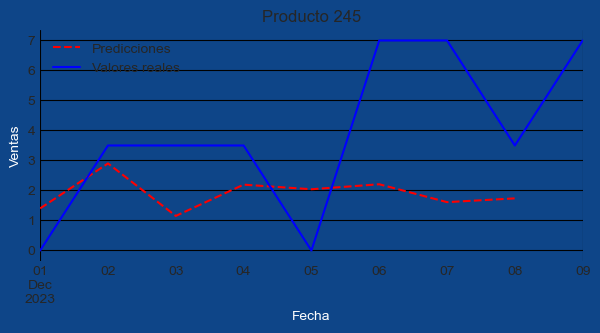

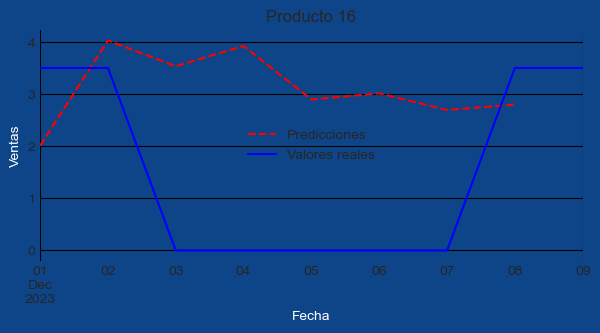

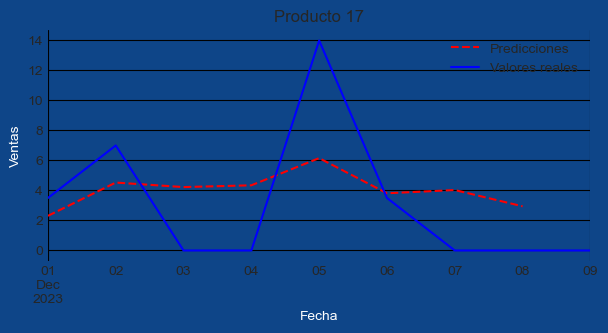

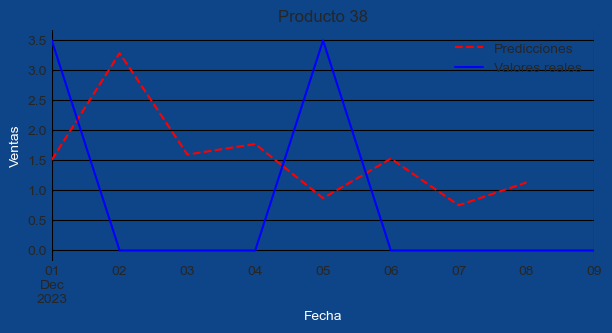

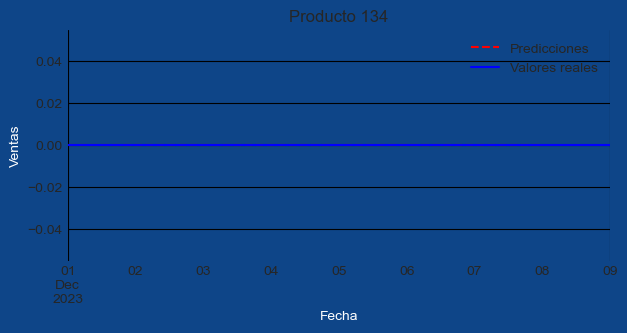

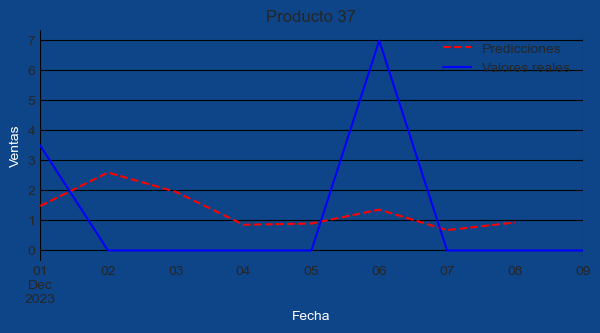

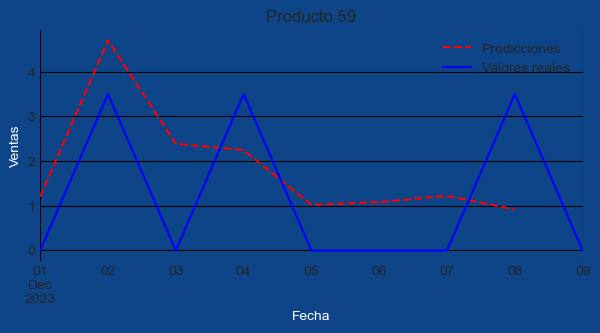

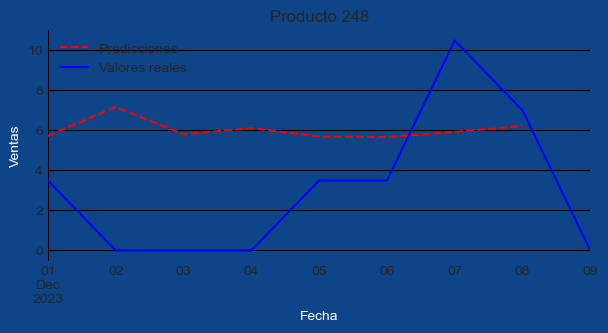

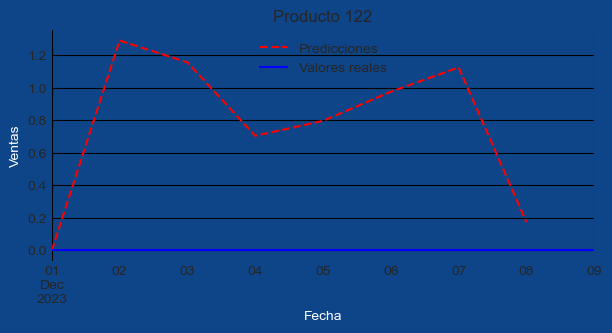

In [22]:
#Save figure
for i in week_pred.columns:
    fig, ax=plt.subplots(figsize=(7, 3))
    week_pred[i].plot(ax=ax,color='red', linestyle='--', label='Predicciones')
    data.loc["2023-12-01":"2023-12-09",i].plot(ax=ax,color='blue', linestyle='-', label='Valores reales')
    ax.set_title(i)
    ax.set_facecolor('#0e4588')
    ax.legend()
    ax.grid(color='black')
    fig.set_facecolor('#0e4588')
    ax.set_ylabel('Ventas',color='white') 
    ax.set_xlabel('Fecha',color='white')
#plt.savefig(f"pred_semanal_sari{i}.png")

## Agregar modelo del otro producto y comparar

In [ ]:
week_pred.to_csv("predicciones_semanales_Sari.csv")
month_pred.to_csv("predicciones_mensuales_Sari.csv")
data.to_csv("datatop20.csv")